In [1]:
import sys
sys.path.append('../src')
from strategies import SAMOracle
import pandas as pd
import json
from os.path import expanduser
import supervision as sv

In [2]:
from prompt_embeddings import *

In [3]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"

In [4]:
df_name = "brain_df"
train_df = pd.read_csv(dataframes_path+"brain_df_train.csv")
test_df = pd.read_csv(dataframes_path+"brain_df_test.csv")

# df_name = "lung_df"
# train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
# test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [5]:
with open("brain_params.json", "r") as f:
    params = json.load(f)
# with open("lung_params.json", "r") as f:
#     params = json.load(f)

# with open("lunar_params.json", "r") as f:
#     params = json.load(f)

In [6]:
params["n_epoch"] = 50
# params["train_args"]["batch_size"]= 4
# params['optimizer_args']={"lr": 5e-6, "momentum": 0.9}

In [7]:
sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

In [8]:
# dens_before_training = sam.mask_predictor.model.prompt_encoder.no_mask_embed.weight.clone().cpu()

In [9]:
# prompt_model = PromptEmbeddings(sparse_in_channels=2, sparse_out_channels=256,
#                                dense_in_channels=1, dense_out_channels=256)

prompt_model = PromptEmbeddings(in_channels=1, out_channels=256)

In [10]:
weights_0 = prompt_model.learnable_weights.weight.clone().cpu()
embeddings_0 = prompt_model.learnable_embeddings.weight.clone().cpu()

In [11]:
# init_sparse, init_dense = prompt_model.sparse_layer.weight.clone(), prompt_model.dense_layer.weight.clone()

In [12]:
# init_sparse, init_dense = prompt_model.sparse_layer.weight.clone(), prompt_model.dense_layer.weight.clone()

In [13]:
prompt_net = PromptNet(model=prompt_model,
                      sam=sam,
                      params=params,
                      df=train_df[:100])

In [14]:
# low_res_masks = train(strategy.dataset.get_labeled_data()[0])
# learnable_sparse_embeddings, learnable_dense_embeddings = prompt_net.train()
prompt_net.train()
# masks = train(strategy.dataset.get_labeled_data()[0])

100%|███████████████████████████████████████████████████| 50/50 [14:10<00:00, 17.01s/it, loss=0.925]


In [15]:
weights_1 = prompt_model.learnable_weights.weight.clone().cpu()
embeddings_1 = prompt_model.learnable_embeddings.weight.clone().cpu()
print((weights_1 == weights_0).float().sum())
print((embeddings_1 == embeddings_0).float().sum())

tensor(0.)
tensor(148.)


In [16]:
embeddings_1.shape

torch.Size([256, 4096])

In [17]:
# Z_hat_T = torch.rand(256, 64, 64)
# Z_T_default = torch.rand(2,256, 64,64)
# C=Z_T_default.shape[0]
# W_hat_T = torch.rand(C)
# Z_T_SemPrompt = W_hat_T.view(C, 1) *Z_hat_T  +  (1 - W_hat_T.view(C, 1)) * Z_T_default

In [18]:
# for param in prompt_net.sam.mask_predictor.model.mask_decoder.parameters():
#     print(param.requires_grad)

In [19]:
# for param in prompt_net.clf.parameters():
#     print(param.requires_grad) 

In [20]:
# sparse, dense = prompt_net.clf.sparse_layer.weight.cpu(), prompt_net.clf.dense_layer.weight.cpu()

In [21]:
# sum(sparse == init_sparse.cpu()).float()

In [22]:
# dens_after_training = sam.mask_predictor.model.prompt_encoder.no_mask_embed.weight

In [23]:
# dens_0 = sam_0.mask_predictor.model.prompt_encoder.no_mask_embed.weight

In [24]:
# (dens_after_training.cpu() == dens_0.cpu()).float().sum()

In [25]:
test_df["masks"][0]

'/home/jovyan/Active-Learning-Segmentation/data/processed/Brain_MRI_segmentation/masks/brain_TCGA_HT_7884_19980913_11_mask.npy'

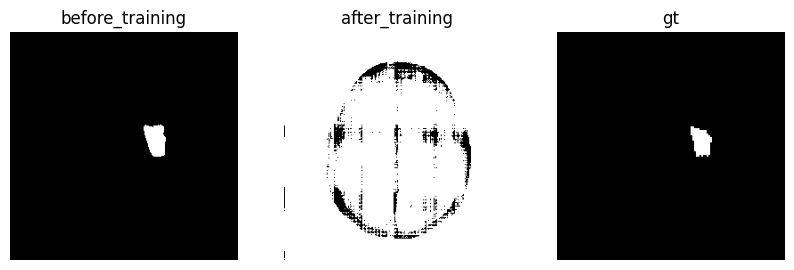

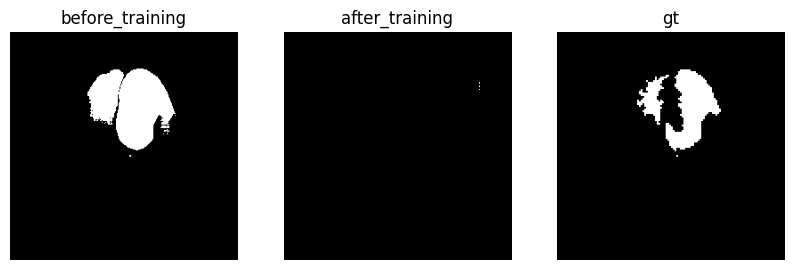

No boxes found
Error by : 2
No boxes found
Error by : 3


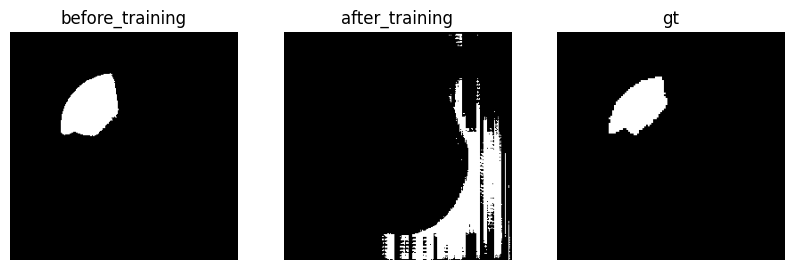

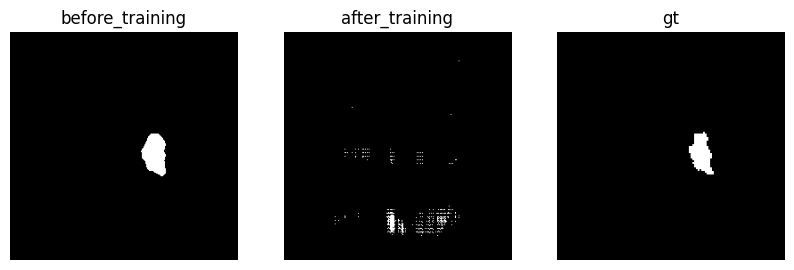

No boxes found
Error by : 6
No boxes found
Error by : 7


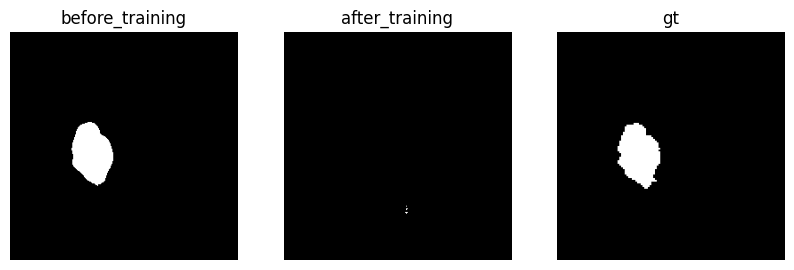

No boxes found
Error by : 9
No boxes found
Error by : 10


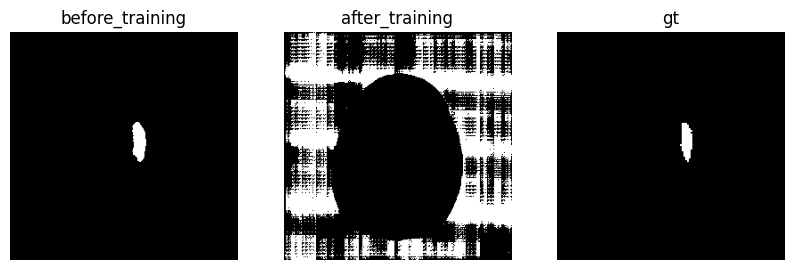

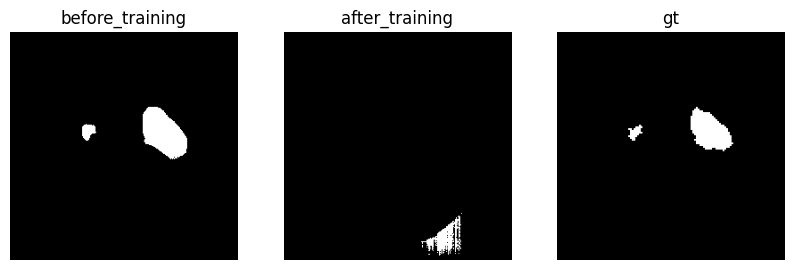

No boxes found
Error by : 13
No boxes found
Error by : 14
No boxes found
Error by : 15
No boxes found
Error by : 16
No boxes found
Error by : 17
No boxes found
Error by : 18
No boxes found
Error by : 19
No boxes found
Error by : 20


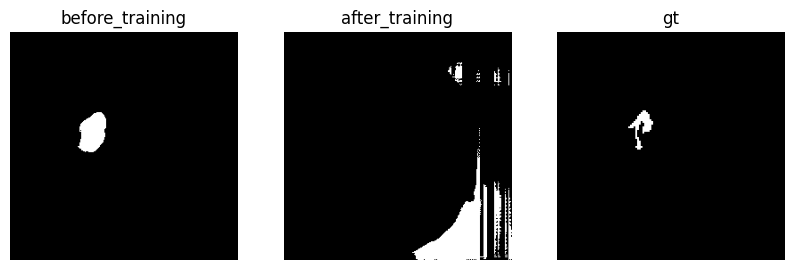

No boxes found
Error by : 22
No boxes found
Error by : 23
No boxes found
Error by : 24
No boxes found
Error by : 25
No boxes found
Error by : 26
No boxes found
Error by : 27
No boxes found
Error by : 28


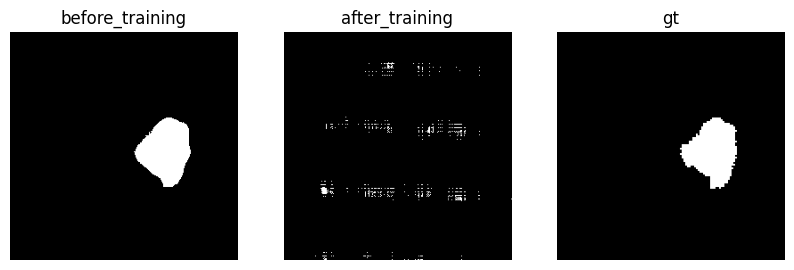

In [35]:
for idx in range(30):
    try:
        # print(idx)
        sam_mask_1 = prompt_net.predict(img_path=test_df["images"][idx], mask_path=test_df["masks"][idx])
        gt_mask = cv2.resize(np.load(test_df["masks"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC)
        sam_mask_0 = cv2.resize(np.load(test_df["oracle"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC)
        
        sv.plot_images_grid(
            images=[sam_mask_0, sam_mask_1, gt_mask],
            grid_size=(1, 3),
            titles=["before_training", "after_training", "gt"],
            size=(10,10)
            
        )
    except:
        print("Error by :", idx)

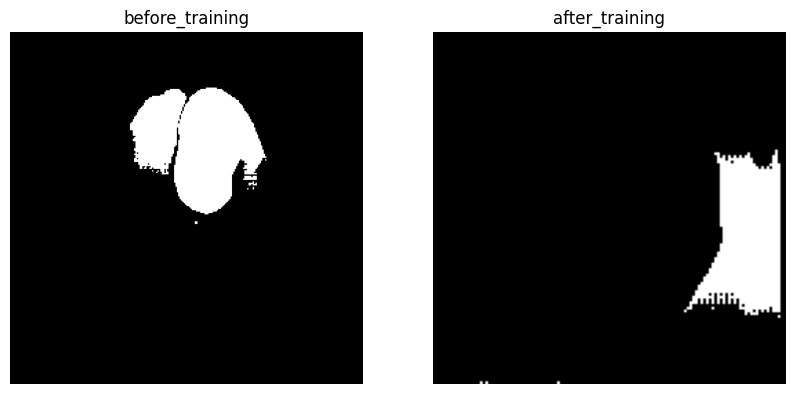

In [27]:
idx = 1
boxes = sam.get_boxes(cv2.resize(np.load(test_df["masks"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC))
mask_1 = sam.get_mask(test_df["images"][idx], boxes=boxes)
mask_0 = cv2.resize(np.load(test_df["oracle"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC)


sv.plot_images_grid(
    images=[mask_0, mask_1],
    grid_size=(1, 2),
    titles=["before_training", "after_training"],
    size=(10,10)
    
)

In [33]:
torch.save(prompt_model.state_dict(), "prompt_model.pt")

In [29]:
# mask = (low_res_masks.cpu().sigmoid()> 0.5).float()

In [30]:
# optimizer = optim.SGD(prompt_net.clf.parameters(), lr=5e-5, momentum=0.5)
# optimizer = optim.SGD(prompt_net.sam.mask_predictor.model.mask_decoder.parameters(), lr=5e-5, momentum=0.5)

In [31]:
# optimizer.step()

In [32]:
# optimizer.param_groups